In [16]:
!pip install openai


In [23]:
from google.colab import userdata
import openai

# 👇 Fetch API key from Colab sidebar secrets
api_key = userdata.get("OPENAI_API_KEY")

# ✅ Set it for OpenAI client
openai.api_key = api_key


In [24]:
print("Key loaded? ✅" if openai.api_key else "Key missing ❌")


Key loaded? ✅


In [28]:
from openai import OpenAI
from google.colab import userdata

# 👇 Fetch from Colab secret storage
api_key = userdata.get("OPENAI_API_KEY")

# ✅ Initialize client
client = OpenAI(api_key=api_key)

def ask_gpt(prompt, temperature=0.7, top_p=0.9, max_tokens=200, model="gpt-3.5-turbo"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an expert in aspect-based sentiment analysis."},
            {"role": "user", "content": prompt}
        ],
        temperature=temperature,
        top_p=top_p,
        max_tokens=max_tokens
    )
    return response.choices[0].message.content


In [29]:
review = "The battery life is terrible but the display quality is outstanding."

prompt = f"""
Extract all aspects from the following review, and classify each as Positive, Negative, or Neutral.
Return output in JSON format like this:
[
  {{"aspect": "battery", "sentiment": "negative"}},
  {{"aspect": "screen", "sentiment": "positive"}}
]

Review: "{review}"
"""

print(ask_gpt(prompt, temperature=0.3, top_p=0.9))


```json
[
  {"aspect": "battery life", "sentiment": "negative"},
  {"aspect": "display quality", "sentiment": "positive"}
]
```


In [33]:
!pip install datasets

from datasets import load_dataset
dataset = load_dataset("tomaarsen/setfit-absa-semeval-restaurants")
print(dataset)


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/147k [00:00<?, ?B/s]

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7c19986e2e40>


data/test-00000-of-00001.parquet:   0%|          | 0.00/46.6k [00:00<?, ?B/s]

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7c19986e3230>


Generating train split:   0%|          | 0/3693 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1134 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'span', 'label', 'ordinal'],
        num_rows: 3693
    })
    test: Dataset({
        features: ['text', 'span', 'label', 'ordinal'],
        num_rows: 1134
    })
})


In [34]:
df = dataset["train"].to_pandas()
df[["text", "span", "label"]].sample(5)


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()


,text,span,label
2206,The main downside to the place is the nazi-lik...,noise level,negative
2860,This place doesn't compare with Mamoun's in te...,price,negative
3101,All I can say is $2 pints during happy hour an...,oysters,positive
607,The atmosphere is noisy and the waiters are li...,atmosphere,negative
2797,While Sapphire is certainly not lacking in amb...,decor,positive


In [35]:
import pandas as pd
sample_df = df.sample(30, random_state=42)  # use a small sample first


In [36]:
sample_df.head()

,text,span,label,ordinal
393,"Based on the reviews for dinner, this is a pla...",Dim Sum,negative,0
3560,Just because it's cheap does NOT mean the port...,portions,positive,0
551,This place would be so much better served by b...,served,negative,0
1295,The atmosphere is great!!!,atmosphere,positive,0
818,I went at 6:00 PM specifically for the pre-the...,pre-theater menu,positive,0


In [37]:
def get_prompt(method, sentence, aspect):
    if method == "zero-shot":
        return f"""
Review: "{sentence}"

What is the sentiment (positive, negative, or neutral) about the aspect: "{aspect}"?

Only return the sentiment word.
"""

    elif method == "few-shot":
        return f"""
Examples:
Review: "The service was poor." → Aspect: service → Sentiment: negative
Review: "Loved the food." → Aspect: food → Sentiment: positive

Now analyze this:
Review: "{sentence}"
Aspect: "{aspect}"
Sentiment:"""

    elif method == "cot":
        return f"""
Let's analyze this step-by-step.

Review: "{sentence}"
Aspect: "{aspect}"

Step 1: Identify how the sentence describes the aspect.
Step 2: Determine whether the sentiment is positive, negative, or neutral.
Step 3: Return the sentiment.

Answer:"""


In [38]:
from openai import OpenAI

client = OpenAI(api_key=openai.api_key)  # assuming you've set api_key earlier

def ask_gpt(prompt, temperature=0.3, top_p=0.9):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        top_p=top_p,
        max_tokens=100
    )
    return response.choices[0].message.content.strip().lower()


In [40]:
import pandas as pd

# Sample 10 reviews from your labeled dataset
sample_df = df.sample(10, random_state=42)

# Prompting function
def get_prompt(method, sentence, aspect):
    return f"""
Review: "{sentence}"

What is the sentiment (positive, negative, or neutral) about the aspect: "{aspect}"?

Only return the sentiment word.
"""

# Ask GPT
from openai import OpenAI
client = OpenAI(api_key=openai.api_key)

def ask_gpt(prompt, temperature=0.3, top_p=0.9):
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        top_p=top_p,
        max_tokens=100
    )
    return response.choices[0].message.content.strip().lower()

# Run small experiment
results = []
for _, row in sample_df.iterrows():
    prompt = get_prompt("zero-shot", row["text"], row["span"])
    pred = ask_gpt(prompt, temperature=0.3, top_p=0.9)
    gold = row["label"].lower()
    match = pred.startswith(gold)

    results.append({
        "text": row["text"],
        "aspect": row["span"],
        "gold": gold,
        "predicted": pred,
        "match": match
    })

df_results = pd.DataFrame(results)


In [41]:
accuracy = df_results["match"].mean()
print(f"✅ Zero-shot Accuracy (10 samples): {accuracy:.2%}")
df_results


✅ Zero-shot Accuracy (10 samples): 80.00%


,text,aspect,gold,predicted,match
0,"Based on the reviews for dinner, this is a pla...",Dim Sum,negative,negative,True
1,Just because it's cheap does NOT mean the port...,portions,positive,positive,True
2,This place would be so much better served by b...,served,negative,negative,True
3,The atmosphere is great!!!,atmosphere,positive,positive,True
4,I went at 6:00 PM specifically for the pre-the...,pre-theater menu,positive,positive,True
5,I must warn the reader that the portions sizes...,menu,positive,negative,False
6,"However, they've got the most amazing pastrami...",soups,positive,positive,True
7,"Guacamole+shrimp appetizer was really great, w...",Guacamole+shrimp appetizer,positive,positive,True
8,It saves walking in and waiting for a table in...,table,negative,positive,False
9,"The service was poor, restaurant poorly lit, s...",service,negative,negative,True


In [42]:
def get_prompt(method, sentence, aspect):
    return f"""
Examples:
Review: "The service was poor." → Aspect: service → Sentiment: negative
Review: "Loved the food." → Aspect: food → Sentiment: positive
Review: "The ambiance was okay." → Aspect: ambiance → Sentiment: neutral

Now analyze this:
Review: "{sentence}"
Aspect: "{aspect}"
Sentiment:"""


In [43]:
results = []
for _, row in sample_df.iterrows():
    prompt = get_prompt("few-shot", row["text"], row["span"])
    pred = ask_gpt(prompt, temperature=0.3, top_p=0.9)
    gold = row["label"].lower()
    match = pred.startswith(gold)

    results.append({
        "text": row["text"],
        "aspect": row["span"],
        "gold": gold,
        "predicted": pred,
        "match": match
    })

df_results = pd.DataFrame(results)


In [44]:
accuracy = df_results["match"].mean()
print(f"✅ Few-shot Accuracy (10 samples): {accuracy:.2%}")
df_results


✅ Few-shot Accuracy (10 samples): 90.00%


,text,aspect,gold,predicted,match
0,"Based on the reviews for dinner, this is a pla...",Dim Sum,negative,negative,True
1,Just because it's cheap does NOT mean the port...,portions,positive,positive,True
2,This place would be so much better served by b...,served,negative,negative,True
3,The atmosphere is great!!!,atmosphere,positive,positive,True
4,I went at 6:00 PM specifically for the pre-the...,pre-theater menu,positive,positive,True
5,I must warn the reader that the portions sizes...,menu,positive,negative,False
6,"However, they've got the most amazing pastrami...",soups,positive,positive,True
7,"Guacamole+shrimp appetizer was really great, w...",Guacamole+shrimp appetizer,positive,"positive\n\naspect: ""filet""\nsentiment: positi...",True
8,It saves walking in and waiting for a table in...,table,negative,negative,True
9,"The service was poor, restaurant poorly lit, s...",service,negative,"negative\n\naspect: ""ambiance""\nsentiment: neg...",True


In [45]:
def get_prompt(method, sentence, aspect):
    return f"""
Let's analyze this step-by-step.

Review: "{sentence}"
Aspect: "{aspect}"

Step 1: Identify how the sentence describes the aspect.
Step 2: Determine whether the sentiment is positive, negative, or neutral.
Step 3: Return only the sentiment word (no explanation).

Answer:"""


In [49]:
results = []

for i, row in sample_df.iterrows():
    prompt = get_prompt("cot", row["text"], row["span"])
    pred = ask_gpt(prompt, temperature=0.3, top_p=0.9)
    gold = row["label"].lower()
    match = pred.startswith(gold)

    results.append({
        "sample": i + 1,
        "review": row["text"],
        "aspect": row["span"],
        "gold": gold,
        "gpt_response": pred,
        "match": match
    })

    print(f"\n=== Sample {i+1} ===")
    print(f"Review: {row['text']}")
    print(f"Aspect: {row['span']}")
    print(f"Gold: {gold}")
    print(f"--- GPT Response ---\n{pred}")
    print(f"✅ Match: {match}")



=== Sample 394 ===
Review: Based on the reviews for dinner, this is a place I would reconsider revisiting for that, but definitely not for Dim Sum again.
Aspect: Dim Sum
Gold: negative
--- GPT Response ---
negative
✅ Match: True

=== Sample 3561 ===
Review: Just because it's cheap does NOT mean the portions are small or the food is nasty, IT IS GREAT!
Aspect: portions
Gold: positive
--- GPT Response ---
positive
✅ Match: True

=== Sample 552 ===
Review: This place would be so much better served by being run by a group that actually understands customer service.
Aspect: served
Gold: negative
--- GPT Response ---
negative
✅ Match: True

=== Sample 1296 ===
Review: The atmosphere is great!!!
Aspect: atmosphere
Gold: positive
--- GPT Response ---
positive
✅ Match: True

=== Sample 819 ===
Review: I went at 6:00 PM specifically for the pre-theater menu ($19.95 for roasted tomato soup with chevre, steak frites, creme brulee) and it was marvelous.
Aspect: pre-theater menu
Gold: positive
--- 

In [50]:
accuracy = df_results["match"].mean()
print(f"✅ CoT Accuracy (10 samples): {accuracy:.2%}")
df_results


✅ CoT Accuracy (10 samples): 80.00%


,text,aspect,gold,predicted,match
0,"Based on the reviews for dinner, this is a pla...",Dim Sum,negative,negative,True
1,Just because it's cheap does NOT mean the port...,portions,positive,positive,True
2,This place would be so much better served by b...,served,negative,negative,True
3,The atmosphere is great!!!,atmosphere,positive,positive,True
4,I went at 6:00 PM specifically for the pre-the...,pre-theater menu,positive,positive,True
5,I must warn the reader that the portions sizes...,menu,positive,negative,False
6,"However, they've got the most amazing pastrami...",soups,positive,positive,True
7,"Guacamole+shrimp appetizer was really great, w...",Guacamole+shrimp appetizer,positive,positive,True
8,It saves walking in and waiting for a table in...,table,negative,positive,False
9,"The service was poor, restaurant poorly lit, s...",service,negative,negative,True


In [51]:
def get_prompt(method, sentence, aspect):
    return f"""
You are a sentiment analysis system. Your task is to classify the sentiment of a specific aspect mentioned in a customer review.

Instructions:
- Determine the sentiment polarity (positive, negative, or neutral) toward the given aspect.
- Only return the sentiment word (e.g., positive).

Review: "{sentence}"
Aspect: "{aspect}"
Sentiment:"""


In [53]:
def get_prompt(method, sentence, aspect):
    return f"""
You are a sentiment analysis system. Your task is to classify the sentiment of a specific aspect mentioned in a customer review.

Instructions:
- Determine the sentiment polarity (positive, negative, or neutral) toward the given aspect.
- Only return the sentiment word (e.g., positive).

Review: "{sentence}"
Aspect: "{aspect}"
Sentiment:"""


In [54]:
results = []
for i, row in sample_df.iterrows():
    prompt = get_prompt("instruction", row["text"], row["span"])
    pred = ask_gpt(prompt, temperature=0.3, top_p=0.9)
    gold = row["label"].lower()
    match = pred.startswith(gold)

    results.append({
        "prompt_type": "instruction",
        "review": row["text"],
        "aspect": row["span"],
        "gold": gold,
        "predicted": pred,
        "match": match
    })

    print(f"\n=== Instruction Prompt Sample {i+1} ===")
    print(f"Review: {row['text']}")
    print(f"Aspect: {row['span']}")
    print(f"Gold: {gold}")
    print(f"GPT: {pred}")
    print(f"✅ Match: {match}")



=== Instruction Prompt Sample 394 ===
Review: Based on the reviews for dinner, this is a place I would reconsider revisiting for that, but definitely not for Dim Sum again.
Aspect: Dim Sum
Gold: negative
GPT: negative
✅ Match: True

=== Instruction Prompt Sample 3561 ===
Review: Just because it's cheap does NOT mean the portions are small or the food is nasty, IT IS GREAT!
Aspect: portions
Gold: positive
GPT: positive
✅ Match: True

=== Instruction Prompt Sample 552 ===
Review: This place would be so much better served by being run by a group that actually understands customer service.
Aspect: served
Gold: negative
GPT: negative
✅ Match: True

=== Instruction Prompt Sample 1296 ===
Review: The atmosphere is great!!!
Aspect: atmosphere
Gold: positive
GPT: positive
✅ Match: True

=== Instruction Prompt Sample 819 ===
Review: I went at 6:00 PM specifically for the pre-theater menu ($19.95 for roasted tomato soup with chevre, steak frites, creme brulee) and it was marvelous.
Aspect: pre-t

In [56]:
accuracy = sum(r["match"] for r in results) / len(results)
print(f"\n✅ Instruction Prompt Accuracy: {accuracy:.2%}")



✅ Instruction Prompt Accuracy: 80.00%


In [57]:
def get_prompt(method, sentence, aspect):
    return f"""
You are an expert aspect-based sentiment analysis reviewer working for a Fortune 500 AI company.

Your job is to determine whether the sentiment expressed about a given aspect in a customer review is positive, negative, or neutral.

Review: "{sentence}"
Aspect: "{aspect}"
Answer only with the sentiment word:"""


In [58]:
accuracy = sum(r["match"] for r in results) / len(results)
print(f"\n✅ Instruction Prompt Accuracy: {accuracy:.2%}")



✅ Instruction Prompt Accuracy: 80.00%


In [59]:
def get_prompt(method, sentence, aspect):
    return f"""
Here are some examples:

Review: "The food was great."
Aspect: food
Sentiment: positive

Review: "The staff was rude."
Aspect: staff
Sentiment: negative

Review: "The decor was fine."
Aspect: decor
Sentiment: neutral

Now analyze this review:

Review: "{sentence}"
Aspect: {aspect}
Sentiment:"""


In [60]:
import itertools

temperatures = [0.0, 0.3, 0.7]
top_ps = [0.8, 0.9, 1.0]

results = []

for temp, top_p in itertools.product(temperatures, top_ps):
    correct = 0
    total = 0

    print(f"\n🔍 Testing Few-shot | Temp={temp}, Top_p={top_p}")

    for _, row in sample_df.iterrows():
        prompt = get_prompt("few-shot", row["text"], row["span"])
        pred = ask_gpt(prompt, temperature=temp, top_p=top_p)
        gold = row["label"].lower()
        match = pred.strip().startswith(gold)
        correct += match
        total += 1

    accuracy = correct / total
    print(f"✅ Accuracy: {accuracy:.2%}")

    results.append({
        "temperature": temp,
        "top_p": top_p,
        "accuracy": accuracy
    })



🔍 Testing Few-shot | Temp=0.0, Top_p=0.8
✅ Accuracy: 80.00%

🔍 Testing Few-shot | Temp=0.0, Top_p=0.9
✅ Accuracy: 80.00%

🔍 Testing Few-shot | Temp=0.0, Top_p=1.0
✅ Accuracy: 80.00%

🔍 Testing Few-shot | Temp=0.3, Top_p=0.8
✅ Accuracy: 80.00%

🔍 Testing Few-shot | Temp=0.3, Top_p=0.9
✅ Accuracy: 80.00%

🔍 Testing Few-shot | Temp=0.3, Top_p=1.0
✅ Accuracy: 80.00%

🔍 Testing Few-shot | Temp=0.7, Top_p=0.8
✅ Accuracy: 70.00%

🔍 Testing Few-shot | Temp=0.7, Top_p=0.9
✅ Accuracy: 80.00%

🔍 Testing Few-shot | Temp=0.7, Top_p=1.0
✅ Accuracy: 80.00%


In [61]:
import pandas as pd
df_temp_results = pd.DataFrame(results)
df_temp_results.sort_values(by="accuracy", ascending=False)


,temperature,top_p,accuracy
0,0.0,0.8,0.8
1,0.0,0.9,0.8
2,0.0,1.0,0.8
3,0.3,0.8,0.8
4,0.3,0.9,0.8
5,0.3,1.0,0.8
7,0.7,0.9,0.8
8,0.7,1.0,0.8
6,0.7,0.8,0.7


In [62]:
temperature = 0.7
top_p = 1.0


In [63]:
correct = 0
total = 0

for _, row in sample_df.iterrows():
    prompt = get_prompt("few-shot", row["text"], row["span"])
    pred = ask_gpt(prompt, temperature=0.7, top_p=1.0)
    gold = row["label"].lower()
    match = pred.strip().startswith(gold)
    correct += match
    total += 1

print(f"\n✅ Accuracy with temp=0.7 and top_p=1.0: {correct/total:.2%}")



✅ Accuracy with temp=0.7 and top_p=1.0: 80.00%


In [64]:
def reflect_and_correct(review, aspect, gpt_answer, gold_label):
    reflection_prompt = f"""
You are an expert in sentiment analysis.

Review: "{review}"
Aspect: "{aspect}"
Initial sentiment prediction: "{gpt_answer}"
Actual correct sentiment: "{gold_label}"

Was the initial sentiment correct? Answer Yes or No.
If No, correct the sentiment and explain why.
"""
    return ask_gpt(reflection_prompt, temperature=0.3, top_p=0.9)


In [66]:
results_reflection = []

for i, row in sample_df.iterrows():
    prompt = get_prompt("few-shot", row["text"], row["span"])
    pred = ask_gpt(prompt, temperature=0.7, top_p=1.0).strip().lower()
    gold = row["label"].lower()
    match_before = pred.startswith(gold)

    corrected_pred = pred  # default to original
    reflection_output = ""

    if not match_before:
        reflection_output = reflect_and_correct(row["text"], row["span"], pred, gold)

        # Try to extract corrected label from the reflection output
        for sentiment in ["positive", "negative", "neutral"]:
            if sentiment in reflection_output.lower():
                corrected_pred = sentiment
                break

    match_after = corrected_pred.startswith(gold)

    results_reflection.append({
        "text": row["text"],
        "aspect": row["span"],
        "gold": gold,
        "original_pred": pred,
        "corrected_pred": corrected_pred,
        "reflection_output": reflection_output,
        "match_before": match_before,
        "match_after": match_after
    })


In [67]:
df_reflection = pd.DataFrame(results_reflection)

# Before and After Accuracy
acc_before = df_reflection["match_before"].mean()
acc_after = df_reflection["match_after"].mean()

print(f"\n🎯 Accuracy BEFORE reflection: {acc_before:.2%}")
print(f"🪞 Accuracy AFTER reflection:  {acc_after:.2%}")



🎯 Accuracy BEFORE reflection: 80.00%
🪞 Accuracy AFTER reflection:  90.00%


<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()


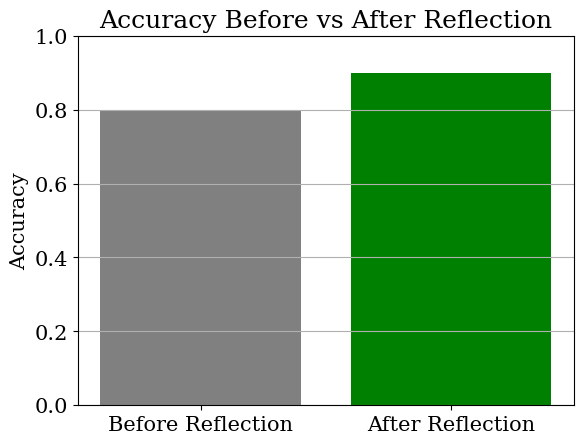

In [68]:
import matplotlib.pyplot as plt

plt.bar(["Before Reflection", "After Reflection"], [acc_before, acc_after], color=["gray", "green"])
plt.title("Accuracy Before vs After Reflection")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()
